In [1]:
%load_ext autoreload
%autoreload 2

import survLime
from survLime.datasets import load_datasets
from survLime import survlime_tabular

import numpy as np
from sksurv.util import Surv

from sksurv.linear_model import CoxPHSurvivalAnalysis
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, StandardScaler

x,y = load_datasets.Loader('veteran')
names = ['celltype_'+name for name in x.celltype.unique()]
x[names] = pd.get_dummies(x.celltype)
x.drop('celltype', inplace=True, axis=1)
get_target = lambda df: df[['status','time']]

In [2]:
X_train, X_test, y_train, y_test = train_test_split(x.copy(), y, test_size=0.4, random_state=1)
X_val, X_test, y_val, y_test = train_test_split(X_test.copy(), y_test, test_size=0.5, random_state=1)
scaler = StandardScaler()

X_train_processed = pd.DataFrame(data=scaler.fit_transform(X_train, y_train),
                                 columns=X_train.columns, index=X_train.index)

X_test_t = pd.DataFrame(data=scaler.transform(X_test),
                                 columns=X_test.columns, index=X_test.index)

#print(hasattr(scaler, "n_features_in_"))
events_train = [x[0] for x in y_train]
times_train  = [x[1] for x in y_train]

events_val = [x[0] for x in y_val]
times_val  = [x[1] for x in y_val]

events_test = [x[0] for x in y_test]
times_test  = [x[1] for x in y_test]

y_train = Surv.from_arrays(events_train, times_train)
y_val   = Surv.from_arrays(events_val, times_val)
y_test  = Surv.from_arrays(events_test, times_test)


In [3]:
model = CoxPHSurvivalAnalysis()
model.fit(X_train_processed, y_train)
model.score(X_test_t.copy(), y_test)

/home/carlos.hernandez/dl/lib/python3.8/site-packages/sksurv/linear_model/coxph.py:433: LinAlgWarning: Ill-conditioned matrix (rcond=3.96842e-17): result may not be accurate.
  delta = solve(optimizer.hessian, optimizer.gradient,
/home/carlos.hernandez/dl/lib/python3.8/site-packages/sksurv/linear_model/coxph.py:433: LinAlgWarning: Ill-conditioned matrix (rcond=9.98832e-18): result may not be accurate.
  delta = solve(optimizer.hessian, optimizer.gradient,
/home/carlos.hernandez/dl/lib/python3.8/site-packages/sksurv/linear_model/coxph.py:433: LinAlgWarning: Ill-conditioned matrix (rcond=1.52627e-17): result may not be accurate.
  delta = solve(optimizer.hessian, optimizer.gradient,
/home/carlos.hernandez/dl/lib/python3.8/site-packages/sksurv/linear_model/coxph.py:433: LinAlgWarning: Ill-conditioned matrix (rcond=2.03557e-17): result may not be accurate.
  delta = solve(optimizer.hessian, optimizer.gradient,


0.7154696132596685

In [4]:
def fill_matrix(total_times, matrix, event_times):
    gl = []
    for time in total_times:
        if time in event_times:
            time_index = event_times.index(time)
            gl.append(matrix[time_index])
        else:
            gl.append(gl[-1])
    return gl

def kernel(d, kernel_width):
    return np.sqrt(np.exp(-(d ** 2) / kernel_width ** 2)) 

In [5]:
from sksurv.nonparametric import nelson_aalen_estimator
from functools import partial
import cvxpy as cp
from math import log
import timeit
import sklearn

Ho_t_ = nelson_aalen_estimator(events_train, times_train)[0] # Unique times [0]; CHF [1]

num_pat = 500

columns = X_test.columns.tolist()
explainer = survlime_tabular.LimeTabularExplainer(X_train_processed, feature_names=columns, class_names=None,
                                                   categorical_features=None, verbose=True, mode='regression', discretize_continuous=False)

synthetic_data = explainer.data_inverse(X_test_t.iloc[0], num_pat) # At [0] we have the data and at [1]
                                                        #the inverse, see what is this
    
# Third step: Obtain the prediction for the synthetic data 
H_i_j = model.predict_cumulative_hazard_function(synthetic_data[1]) # X_test_t -> [371, num_features]
times_to_fill = list(set(times_train))
H_i_j[0]
H_i_j_wc = [fill_matrix(times_to_fill, x.y, list(x.x)) for x in H_i_j]
len(nelson_aalen_estimator(events_train, times_train)[0])

/home/carlos.hernandez/dl/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but CoxPHSurvivalAnalysis was fitted with feature names
  warnings.warn(


66

In [6]:
kernel_fn = partial(kernel, kernel_width=5)

# We need to do the line 362 from survlime_tabular (scale the data)
scaled_data = synthetic_data[0]
distances = sklearn.metrics.pairwise_distances(
            scaled_data,
            scaled_data[0].reshape(1,-1), # <-- Point of inquiry
            metric = 'euclidean').ravel()
weights = kernel_fn(distances)

In [7]:
H_i_j_wc[0].__len__()
H_i_j_wc[0].__len__()
Ho_t_.__len__()

66

In [9]:
start_time = timeit.default_timer()
# code you want to evaluate
timeit.default_timer() - start_time

epsilon = 0.00000001
n = 9 # For now we are only using 3 features
num_times = len(set(times_to_fill))
b = cp.Variable(n)

cost = [weights[k]*cp.square((log(H_i_j_wc[k][j]+epsilon) - log(Ho_t_[j]+epsilon) - b @ scaled_data[k]))\
        for k in range(num_pat) for j in range(num_times)] # *(times_to_fill[j+1]-times_to_fill[j]) 
#cost = [weights[k]*cp.norm((log(H_i_j_wc[k][j]+epsilon) - log(Ho_t_[j]+epsilon) - b @ scaled_data[k]),'inf') \
#                                            for k in range(num_pat) for j in range(num_times)]
print(f'time creating the cost list {timeit.default_timer() - start_time}')

start_time = timeit.default_timer()
cost_sum = cp.sum(cost)

print(f'time summing the cost list {timeit.default_timer() - start_time}')
start_time = timeit.default_timer()

prob = cp.Problem(cp.Minimize(cost_sum))


opt_val = prob.solve(verbose=True)
print(f'time solving the problem {timeit.default_timer() - start_time}')
b.value

time creating the cost list 4.890472266823053
time summing the cost list 9.323433137498796
                                     CVXPY                                     
                                     v1.2.1                                    
(CVXPY) Jul 20 10:21:33 AM: Your problem has 9 variables, 0 constraints, and 0 parameters.
(CVXPY) Jul 20 10:21:36 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 20 10:21:36 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 20 10:21:36 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jul 20 10:21:38 AM: Compiling problem (target solver=OSQP).
(CVXPY

array([-0.18420772, -0.40981409, -0.06208342,  0.31539932, -0.01130377,
       -0.35335319,  0.07474481, -0.13545588,  0.64392186])

In [16]:
df = pd.DataFrame(columns=model.feature_names_in_, 
                  data=[b.value, model.coef_], index=['SurvLIME','CoxPH'])
type(model)
isinstance(model, CoxPHSurvivalAnalysis)

True

 RMSE between the two curves is 0.075


/home/carlos.hernandez/dl/lib/python3.8/site-packages/sksurv/linear_model/coxph.py:433: LinAlgWarning: Ill-conditioned matrix (rcond=3.96842e-17): result may not be accurate.
  delta = solve(optimizer.hessian, optimizer.gradient,
/home/carlos.hernandez/dl/lib/python3.8/site-packages/sksurv/linear_model/coxph.py:433: LinAlgWarning: Ill-conditioned matrix (rcond=9.98832e-18): result may not be accurate.
  delta = solve(optimizer.hessian, optimizer.gradient,
/home/carlos.hernandez/dl/lib/python3.8/site-packages/sksurv/linear_model/coxph.py:433: LinAlgWarning: Ill-conditioned matrix (rcond=1.52627e-17): result may not be accurate.
  delta = solve(optimizer.hessian, optimizer.gradient,
/home/carlos.hernandez/dl/lib/python3.8/site-packages/sksurv/linear_model/coxph.py:433: LinAlgWarning: Ill-conditioned matrix (rcond=2.03557e-17): result may not be accurate.
  delta = solve(optimizer.hessian, optimizer.gradient,


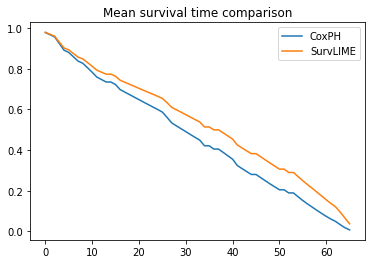

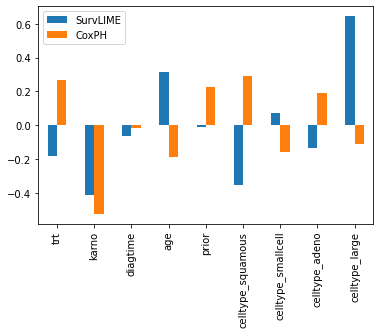

In [17]:
from survLime.utils.generic_utils import compare_survival_times

compare_survival_times(model, b.value, X_train_processed, y_train, X_test_t)

numpy.ndarray

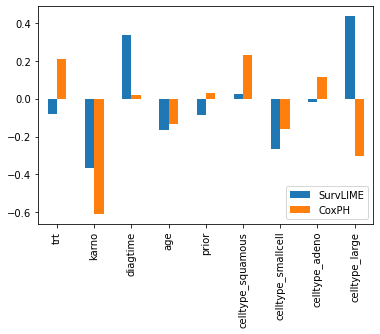

In [183]:
df.transpose().plot.bar()
type(b.value)

In [161]:
import matplotlib.pyplot as plt
model_2 = CoxPHSurvivalAnalysis()
model_2.fit(X_train_processed, y_train)
model_2.coef_ = b.value

/home/carlos.hernandez/dl/lib/python3.8/site-packages/sksurv/linear_model/coxph.py:433: LinAlgWarning: Ill-conditioned matrix (rcond=4.66642e-17): result may not be accurate.
  delta = solve(optimizer.hessian, optimizer.gradient,
/home/carlos.hernandez/dl/lib/python3.8/site-packages/sksurv/linear_model/coxph.py:433: LinAlgWarning: Ill-conditioned matrix (rcond=6.05059e-17): result may not be accurate.
  delta = solve(optimizer.hessian, optimizer.gradient,
/home/carlos.hernandez/dl/lib/python3.8/site-packages/sksurv/linear_model/coxph.py:433: LinAlgWarning: Ill-conditioned matrix (rcond=4.04011e-17): result may not be accurate.
  delta = solve(optimizer.hessian, optimizer.gradient,
/home/carlos.hernandez/dl/lib/python3.8/site-packages/sksurv/linear_model/coxph.py:433: LinAlgWarning: Ill-conditioned matrix (rcond=5.05028e-17): result may not be accurate.
  delta = solve(optimizer.hessian, optimizer.gradient,
/home/carlos.hernandez/dl/lib/python3.8/site-packages/sksurv/linear_model/coxph.

In [162]:
preds_cox      = model.predict_survival_function(X_test_t)
preds_survlime = model_2.predict_survival_function(X_test_t)

preds_cox_y  = [x.y for x in preds_cox]
preds_surv_y = [x.y for x in preds_survlime]

In [163]:
len(preds_cox_y)
prueba = np.mean(preds_cox_y, axis=0)
prueba_surv = np.mean(preds_surv_y, axis=0)

In [186]:
type(X_test_t)

pandas.core.frame.DataFrame

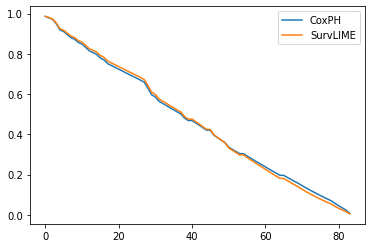

In [181]:
plt.plot(prueba, label='CoxPH')
plt.plot(prueba_surv, label='SurvLIME')
plt.legend()


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/home/carlos.hernandez/dl/lib/python3.8/site-packages/sksurv/linear_model/coxph.py:433: LinAlgWarning: Ill-conditioned matrix (rcond=3.96842e-17): result may not be accurate.
  delta = solve(optimizer.hessian, optimizer.gradient,
/home/carlos.hernandez/dl/lib/python3.8/site-packages/sksurv/linear_model/coxph.py:433: LinAlgWarning: Ill-conditioned matrix (rcond=9.98832e-18): result may not be accurate.
  delta = solve(optimizer.hessian, optimizer.gradient,
/home/carlos.hernandez/dl/lib/python3.8/site-packages/sksurv/linear_model/coxph.py:433: LinAlgWarning: Ill-conditioned matrix (rcond=1.52627e-17): result may not be accurate.
  delta = solve(optimizer.hessian, optimizer.gradient,
/home/carlos.hernandez/dl/lib/python3.8/site-packages/sksurv/linear_model/coxph.py:433: LinAlgWarning: Ill-conditioned matrix (rcond=2.03557e-17): result may not be accurate.
  delta = solve(optimizer.hessian, optimizer.gradient,


NameError: name 'b' is not defined